In [ ]:
# CS 8316 – BIG DATA PROGRAMMING  
## Group Assignment Report

### Group Members#ANSWERS
1. Handling Missing Values:

For handling missing values in the Telco dataset, especially in the columns like "Monthly Charges" and "Total Charges", imputation techniques such as mean, median, or mode are commonly used. For "Monthly Charges" and "Total Charges", imputation with the median or mean can work well. The median is particularly useful if the distribution is skewed, while the mean might be more appropriate if the data is normally distributed.

Effectively handling missing values is essential because features like "Monthly Charges" and "Total Charges" are key predictors of customer churn. Proper imputation ensures valuable data is retained, allowing the model to leverage all available information. Failing to address missing values can lead to biased predictions and decreased model performance.

2. Handling Outliers:

Outliers in "Monthly Charges" or "Total Charges" might be genuine (such as high-paying customers) or due to errors. Instead of removing them without investigation, it’s best to first analyze whether the outliers are valid.

If they represent valid customer behavior, they should be kept as they could provide valuable insights for predicting churn. However, if the outliers are errors or do not contribute meaningfully to the prediction, they should be removed or corrected. This approach ensures that we maintain valuable data while improving the model’s accuracy.

3. Handling Categorical Values:

For features like "Contract", "Internet Service", and "Phone Service", we need to convert these categorical variables into numerical values that the machine learning model can interpret.

Label Encoding:
For ordinal categorical variables (where the values have a meaningful order), such as "Contract" with values like "Month-to-Month", "One Year", and "Two Year", label encoding can be used. Each category would be assigned an integer (e.g., "Month-to-Month" = 0, "One Year" = 1, "Two Year" = 2).

One-Hot Encoding:
For nominal categorical variables (where there is no meaningful order), such as "Internet Service" or "Phone Service", one-hot encoding should be used. This creates a binary column for each category (e.g., for "Internet Service", there would be columns for "Fiber Optic" and "DSL", and the values would be 0 or 1 depending on the customer’s service type).

Proper encoding ensures the machine learning model understands the relationship between categorical variables and the target variable (churn). This transformation allows the model to work effectively with non-numerical data, making it possible to make accurate predictions.

4. Handling the Tenure Column:

Binning and Mapping:
We transformed the "Tenure" feature into categories using binning. We divided the tenure into four categories:

"Short" (0–12 months)

"Medium" (13–24 months)

"Long" (25–36 months)

"Very Long" (36+ months)

Each category was then mapped to a numerical value:

"Short" = 0

"Medium" = 1

"Long" = 2

"Very Long" = 3

Finally, we dropped the original "Tenure" and "TenureCategory" columns, leaving only the transformed numeric version for use in the model.

Binning and mapping "Tenure" into categories allows the model to capture patterns related to customer loyalty more effectively. It simplifies the data, making it easier for the model to identify trends, and prevents the model from being impacted by extreme tenure values. This transformation also improves interpretability by converting the feature into meaningful categories.

5. Data Integration:

We would have combined the service information (like "Speed" and "Data Allowance") with the Telco dataset by matching them using a shared column called "CustomerID".

After combining the data, we would have fixed the missing details for some customers. For "Speed", we would have filled the gaps with the most common value (mode). For "Data Allowance", we would have used the average (mean) to fill the gaps.

We would have also added a new column called "ServiceInfoMissing" to mark customers with missing details. If a customer was missing data, this column would have shown a value of 1; otherwise, it would have shown 0.

Adding the service information would have improved the dataset for predicting which customers might leave (churn). Fixing and marking missing details would have kept the data accurate and reliable for the prediction model.

Code Example for the Above
# Merging datasets on CustomerID
combined_data = pd.merge(data, service_data, on='CustomerID', how='left')

# 'service_data' is the data we originally have
# service_data is the additional data with service information

# Impute missing values
combined_data['Speed'].fillna(combined_data['Speed'].mode()[0], inplace=True)
combined_data['Data Allowance'].fillna(combined_data['Data Allowance'].mean(), inplace=True)

# Flag missing data
combined_data['ServiceInfoMissing'] = combined_data[['Speed', 'Data Allowance']].isnull().any(axis=1).astype(int)


Error Message:

NameError                                 Traceback (most recent call last)
Cell In[70], line 3
    1 # Merging datasets on CustomerID
    2 combined_data = pd.merge(data, service_data, on='CustomerID', how='left')
    3
NameError: name 'service_data' is not defined

6. Feature Selection:

For feature selection, we used Recursive Feature Elimination (RFE) to identify and remove irrelevant features from the Telco dataset. RFE helps select the most important features by recursively removing the least important ones based on model performance. By applying RFE, we eliminated features like "CustomerID" that are not useful for churn prediction, improving model efficiency and focusing on the most relevant data.

7. Data Imbalance:

As stated, customer churn is a relatively rare event compared to non-churn, which can lead to class imbalance in the dataset. This imbalance may cause the model to be biased toward predicting the majority class (non-churn), potentially reducing the model’s ability to identify churned customers accurately.

To address this, we applied SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors). SMOTEENN is an effective technique for handling class imbalance because it works by generating synthetic samples for the minority class (churn) while removing noise from the dataset using Edited Nearest Neighbors.

This approach helps balance the dataset by generating samples for churned customers, which improves the model’s ability to predict both churn and non-churn instances accurately.
1. Elikana Jeremiah Dakho  
2. Valerian Onesmo  #ANSWERS
1. Handling Missing Values:

For handling missing values in the Telco dataset, especially in the columns like "Monthly Charges" and "Total Charges", imputation techniques such as mean, median, or mode are commonly used. For "Monthly Charges" and "Total Charges", imputation with the median or mean can work well. The median is particularly useful if the distribution is skewed, while the mean might be more appropriate if the data is normally distributed.

Effectively handling missing values is essential because features like "Monthly Charges" and "Total Charges" are key predictors of customer churn. Proper imputation ensures valuable data is retained, allowing the model to leverage all available information. Failing to address missing values can lead to biased predictions and decreased model performance.

2. Handling Outliers:

Outliers in "Monthly Charges" or "Total Charges" might be genuine (such as high-paying customers) or due to errors. Instead of removing them without investigation, it’s best to first analyze whether the outliers are valid.

If they represent valid customer behavior, they should be kept as they could provide valuable insights for predicting churn. However, if the outliers are errors or do not contribute meaningfully to the prediction, they should be removed or corrected. This approach ensures that we maintain valuable data while improving the model’s accuracy.

3. Handling Categorical Values:

For features like "Contract", "Internet Service", and "Phone Service", we need to convert these categorical variables into numerical values that the machine learning model can interpret.

Label Encoding:
For ordinal categorical variables (where the values have a meaningful order), such as "Contract" with values like "Month-to-Month", "One Year", and "Two Year", label encoding can be used. Each category would be assigned an integer (e.g., "Month-to-Month" = 0, "One Year" = 1, "Two Year" = 2).

One-Hot Encoding:
For nominal categorical variables (where there is no meaningful order), such as "Internet Service" or "Phone Service", one-hot encoding should be used. This creates a binary column for each category (e.g., for "Internet Service", there would be columns for "Fiber Optic" and "DSL", and the values would be 0 or 1 depending on the customer’s service type).

Proper encoding ensures the machine learning model understands the relationship between categorical variables and the target variable (churn). This transformation allows the model to work effectively with non-numerical data, making it possible to make accurate predictions.

4. Handling the Tenure Column:

Binning and Mapping:
We transformed the "Tenure" feature into categories using binning. We divided the tenure into four categories:

"Short" (0–12 months)

"Medium" (13–24 months)

"Long" (25–36 months)

"Very Long" (36+ months)

Each category was then mapped to a numerical value:

"Short" = 0

"Medium" = 1

"Long" = 2

"Very Long" = 3

Finally, we dropped the original "Tenure" and "TenureCategory" columns, leaving only the transformed numeric version for use in the model.

Binning and mapping "Tenure" into categories allows the model to capture patterns related to customer loyalty more effectively. It simplifies the data, making it easier for the model to identify trends, and prevents the model from being impacted by extreme tenure values. This transformation also improves interpretability by converting the feature into meaningful categories.

5. Data Integration:

We would have combined the service information (like "Speed" and "Data Allowance") with the Telco dataset by matching them using a shared column called "CustomerID".

After combining the data, we would have fixed the missing details for some customers. For "Speed", we would have filled the gaps with the most common value (mode). For "Data Allowance", we would have used the average (mean) to fill the gaps.

We would have also added a new column called "ServiceInfoMissing" to mark customers with missing details. If a customer was missing data, this column would have shown a value of 1; otherwise, it would have shown 0.

Adding the service information would have improved the dataset for predicting which customers might leave (churn). Fixing and marking missing details would have kept the data accurate and reliable for the prediction model.

Code Example for the Above
# Merging datasets on CustomerID
combined_data = pd.merge(data, service_data, on='CustomerID', how='left')

# 'service_data' is the data we originally have
# service_data is the additional data with service information

# Impute missing values
combined_data['Speed'].fillna(combined_data['Speed'].mode()[0], inplace=True)
combined_data['Data Allowance'].fillna(combined_data['Data Allowance'].mean(), inplace=True)

# Flag missing data
combined_data['ServiceInfoMissing'] = combined_data[['Speed', 'Data Allowance']].isnull().any(axis=1).astype(int)


Error Message:

NameError                                 Traceback (most recent call last)
Cell In[70], line 3
    1 # Merging datasets on CustomerID
    2 combined_data = pd.merge(data, service_data, on='CustomerID', how='left')
    3
NameError: name 'service_data' is not defined

6. Feature Selection:

For feature selection, we used Recursive Feature Elimination (RFE) to identify and remove irrelevant features from the Telco dataset. RFE helps select the most important features by recursively removing the least important ones based on model performance. By applying RFE, we eliminated features like "CustomerID" that are not useful for churn prediction, improving model efficiency and focusing on the most relevant data.

7. Data Imbalance:

As stated, customer churn is a relatively rare event compared to non-churn, which can lead to class imbalance in the dataset. This imbalance may cause the model to be biased toward predicting the majority class (non-churn), potentially reducing the model’s ability to identify churned customers accurately.

To address this, we applied SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors). SMOTEENN is an effective technique for handling class imbalance because it works by generating synthetic samples for the minority class (churn) while removing noise from the dataset using Edited Nearest Neighbors.

This approach helps balance the dataset by generating samples for churned customers, which improves the model’s ability to predict both churn and non-churn instances accurately.

---


In [111]:
import pandas as pd
import numpy as  np
import seaborn  as sns
import matplotlib.pyplot as plt

In [112]:
# Load the dataset
df = pd.read_csv("/home/karera/Desktop/SEMISTER11/big data/Churndata(1).csv")


In [114]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [115]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [116]:
df.shape

(7043, 21)

In [117]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [118]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [120]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [121]:
df.duplicated().sum()

np.int64(0)

In [122]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [123]:
# Convert 'TotalCharges' to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


In [124]:

# Check missing values across all columns
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [125]:
# Optional: If any other numeric columns had missing values, fill with median
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in {col} with median: {median_val}")


Imputed missing values in TotalCharges with median: 1397.475


/tmp/ipykernel_4624/900270614.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [126]:

# Check missing values across all columns
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


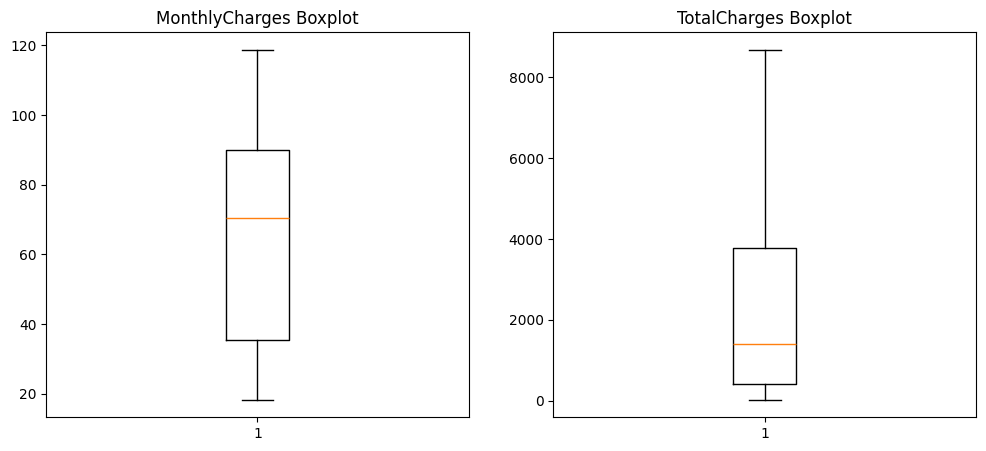

MonthlyCharges outliers count: 0
TotalCharges outliers count: 0
After capping:
       MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2281.916928
std         30.090047   2265.270398
min         18.250000     18.800000
25%         35.500000    402.225000
50%         70.350000   1397.475000
75%         89.850000   3786.600000
max        118.750000   8684.800000


In [127]:
# step 2: outlier  detection  and  treatmet
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Visualize outliers
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.boxplot(df['MonthlyCharges'])
plt.title('MonthlyCharges Boxplot')

plt.subplot(1, 2, 2)
plt.boxplot(df['TotalCharges'])
plt.title('TotalCharges Boxplot')

plt.show()

# Step 2: Detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

monthly_outliers = detect_outliers_iqr(df, 'MonthlyCharges')
total_outliers = detect_outliers_iqr(df, 'TotalCharges')

print("MonthlyCharges outliers count:", monthly_outliers.shape[0])
print("TotalCharges outliers count:", total_outliers.shape[0])

# Step 3: Cap outliers (Winsorization)
def cap_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

cap_outliers_iqr(df, 'MonthlyCharges')
cap_outliers_iqr(df, 'TotalCharges')

# Step 4: Verify
print("After capping:")
print(df[['MonthlyCharges','TotalCharges']].describe())


In [142]:
# ---------------------------
# Data Transformation: Categorical Encoding + Tenure Grouping
# ---------------------------

# 1️⃣ Transform 'tenure' into interpretable bins
df["TenureGroup"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 72],
    labels=["0-1yr", "1-2yr", "2-4yr", "4-6yr"]
)

# 2️⃣ Identify categorical and numerical features
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

numerical_features = ["SeniorCitizen", "tenure", "MonthlyCharges"]

# 3️⃣ Build preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# 4️⃣ Apply transformations
X = df[numerical_features + categorical_features]
y = df["Churn"].map({"No": 0, "Yes": 1})

X_transformed = preprocessor.fit_transform(X)

print("Data Transformation completed!")
print("Transformed feature shape:", X_transformed.shape)


Data Transformation completed!
Transformed feature shape: (7043, 32)


In [145]:
#Drop irrelevant columns
df.drop(['customerID'], axis=1, inplace=True, errors='ignore')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,TenureGroup,Speed_x,DataAllowance_x,Speed_y,DataAllowance_y,Speed,DataAllowance
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.85,29.85,No,0-1yr,25.0,500.0,25.0,500.0,25.0,500.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,56.95,1889.50,No,2-4yr,25.0,500.0,25.0,500.0,25.0,500.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,53.85,108.15,Yes,0-1yr,25.0,500.0,25.0,500.0,25.0,500.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,42.30,1840.75,No,2-4yr,25.0,500.0,25.0,500.0,25.0,500.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,70.70,151.65,Yes,0-1yr,100.0,2000.0,100.0,2000.0,100.0,2000.0


In [144]:
# ---------------------------
# Correct numeric and categorical features
# ---------------------------
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "Speed", "DataAllowance"]
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

# ---------------------------
# ColumnTransformer
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# ---------------------------
# Full Pipeline with SMOTE + Logistic Regression
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ---------------------------
# Feature matrix and target
# ---------------------------
X = df[numeric_features + categorical_features]
y = df["Churn"].map({"No": 0, "Yes": 1})

# ---------------------------
# Train/test split
# ---------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# Train the model
# ---------------------------
model.fit(X_train, y_train)
print("Pipeline with integrated internet plans trained successfully!")

# ---------------------------
# Check transformed feature shape
# ---------------------------
X_transformed = preprocessor.fit_transform(X)
print("Transformed feature shape:", X_transformed.shape)


Pipeline with integrated internet plans trained successfully!
Transformed feature shape: (7043, 34)


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

# ---------------------------
# Define raw features and target
# ---------------------------
raw_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "TenureGroup"
]

X = df[raw_features].copy()
y = df["Churn"].map({"No": 0, "Yes": 1})

# ---------------------------
# Identify numeric and categorical features
# ---------------------------
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges"]
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "TenureGroup"
]

# ---------------------------
# Build preprocessing pipelines
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# ---------------------------
# Build full pipeline with VarianceThreshold (Data Reduction) + SMOTE + Logistic Regression
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance_threshold", VarianceThreshold(threshold=0.01)),  # Data Reduction
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ---------------------------
# Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# Train the pipeline
# ---------------------------
model.fit(X_train, y_train)
print("Pipeline with Data Reduction trained successfully!")

# ---------------------------
# Check which features were kept after reduction
# ---------------------------
selected_features_mask = model.named_steps['variance_threshold'].get_support()
preprocessed_features = model.named_steps['preprocessor'].get_feature_names_out()
selected_features = preprocessed_features[selected_features_mask]

print("Number of features before reduction:", len(preprocessed_features))
print("Number of features after reduction:", len(selected_features))
print("Selected Features:", selected_features)


Pipeline with Data Reduction trained successfully!
Number of features before reduction: 32
Number of features after reduction: 32
Selected Features: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges'
 'cat__gender_Male' 'cat__Partner_Yes' 'cat__Dependents_Yes'
 'cat__PhoneService_Yes' 'cat__MultipleLines_No phone service'
 'cat__MultipleLines_Yes' 'cat__InternetService_Fiber optic'
 'cat__InternetService_No' 'cat__OnlineSecurity_No internet service'
 'cat__OnlineSecurity_Yes' 'cat__OnlineBackup_No internet service'
 'cat__OnlineBackup_Yes' 'cat__DeviceProtection_No internet service'
 'cat__DeviceProtection_Yes' 'cat__TechSupport_No internet service'
 'cat__TechSupport_Yes' 'cat__StreamingTV_No internet service'
 'cat__StreamingTV_Yes' 'cat__StreamingMovies_No internet service'
 'cat__StreamingMovies_Yes' 'cat__Contract_One year'
 'cat__Contract_Two year' 'cat__PaperlessBilling_Yes'
 'cat__PaymentMethod_Credit card (automatic)'
 'cat__PaymentMethod_Electronic check' 'cat__Payment

In [150]:
# Count number of churned and non-churned customers
churn_counts = df['Churn'].value_counts()
print("Churn class distribution:")
print(churn_counts)

# Calculate percentage of each class
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print("\nChurn class distribution (%):")
print(churn_percent)


Churn class distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn class distribution (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [148]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X_train, drop_first=True)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_encoded, y_train)

# Check new distribution
from collections import Counter
print("Training set class distribution after SMOTE:")
print(Counter(y_train_resampled))


Training set class distribution after SMOTE:
Counter({0: 4139, 1: 4139})
